# MGSC 404 Foundations of Decision Analytics - Fall 2019

# Case Study

### Team Members: Andrew Debay (260804092), Carol Shen (260763760), Huaide Huang(260791906)

## Section I: Introduction

American Office Systems, Inc. is a full-service computer equipment dealership provider. It’s currently selling two types of adapters for copy machines compatible with IBM and Mac computers. The goal of top managers of the company is to prepare a feasible plan for 1996 and make a decision about how to allocate funds between production and advertising so that all the cash flow, financial, accounting, marketing, inventory, and production considerations are taken into account and the end of year profit is maximized. The plan must specify the amount of each product to produce per quarter and the amount of inventory while keeping the minimum inventory requirements in mind. It is also necessary to see that production and end of period inventory be at least 10% more than the estimated sales of the next quarter and at least twice the maximum expected sales for that quarter in order to prevent a shortage. The revenue of our company comes from the sales of two types of adapters this year, and the interest from investing the excess cash in government securities. The costs incurred are the fixed operating costs, production costs, inventory holding costs, advertising costs, and the interest that we pay on the bank loan that we take for each quarter. 

Through forming a model in Section II, our optimal solution for American Office Systems currently predicts that the company will make a profit of $ 10,475,777 at the end of year 1996. Furthermore, several sensitivity analysis will be taken in order to analyze ways of improving the efficiency of company operation on different aspects.

## Section II: Model 


**Assumptions**

Our model relies on the following assumptions:

1. American Office Systems, Inc. runs 2 work shifts of 8 hours every day for 20 days per month. Each quarter is made of 3 months therefore we made our full capacity the number of adapters for IBM and MAC produced each hour multiplied by the hours worked in a quarter. 
2. Forecasted sales are accurate.
3. They are able to secure 750,000 line of credit for the coming year and interest rate is 16%.
4. We immediately pay the interest for borrowing in the previous quarter at the end of the following quarter.
5. We immediately pay back the full amount of borrowing in the previous quarter at the end of the following quarter. It means the line of credit is reset to 750,000 for every quarter.
6. Using a linear model is an appropriate approximation for an optimal strategy and further refinement will be done later. 
7. This model optimizes the accounting profit instead of the present and future cash flows of the operations. We opted for that sort of model because it depicts better the reality of the company and we found that, with the cash flow based models, the ending inventory of the last quarter was often too low to prepare for next year.
8. The fixed costs of 3 million dollars are for the whole company and only a portion is attributable to the adapters. We decided that 500,000 would be a good starting point.
9. There is 1% per month inventory carry cost, which means 3% per quarter.
10. If any excess cash is available in each quarter, the company policy is to invest it in short-term government securities and during the coming year, the yield of return is estimated to be 6%.
11. Interest rates of borrowing is compound interest rates and short-term government investment yield is simple return.



In [1]:
from gurobipy import *
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math

#### Step 1: Creating a Gurobi object

In [2]:
model = Model('case study')  

Academic license - for non-commercial use only


#### Step 2: Defining Decision Variables

**Pi** = Production for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4             
**Pm** =  Production for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Si** = Sales for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Sm** = Sales for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Mi** = Marketing for IBM adapters in units of additional adapter units sold due to marketing activities, in quarters i, where i = 1,2,3,4   
**Mm** = Marketing for MAC adapters in units of additional adapter units sold due to marketing activities, in quarters i, where i = 1,2,3,4  <br />
**B  =** Amount borrowed from the line of credit in units of dollars, in quarters i, where i = 1,2,3,4 <br />
**Ei** = Ending inventory for IBM adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**Em** = Ending inventory for MAC adapters in units of adapters, in quarters i, where i = 1,2,3,4   
**CF** =Cash flow at the end of the quarter in units of dollars, in quarters i, where i = 1,2,3,4   


In [3]:
#initilizing empty dictionaries
Pi = {}  
Pm = {} 
Si = {} 
Sm = {} 
Mi = {} 
Mm = {} 
B = {} 
Ei = {}
Em = {} 
CF={}

# Create decisions variable
for i in np.arange(4):  
    Pi[i] = model.addVar(lb=0)
    Pm[i] = model.addVar(lb=0)
    Si[i] = model.addVar(lb=0)
    Sm[i] = model.addVar(lb=0)
    Mi[i] = model.addVar(lb=0)
    Mm[i] = model.addVar(lb=0)
    B[i] = model.addVar(lb=0)
    CF[i] = model.addVar(lb=0)
    Ei[i] = model.addVar(lb=0)
    Em[i] = model.addVar(lb=0)
    # It is optional to specify the lower and upper bounds of the variable, as the defaults are suitable for our case

#### Step 3: Parameters

**price_ibm** = the selling price for IBM adapters  

**price_mac** = the selling price for MAC adapters  

**VC_ibm** =  the variable costs for IBM adapters 

**VC_mac** =  the variable costs for MAC adapters 

**beginning_inventory_ibm** =  the beginning inventory for IBM adapters at Q1  

**beginning_inventory_mac** =  the beginning inventory for MAC adapters at Q1 

**cost_advertising** =  the cost to sell one additional unit of either an IBM or MAC adapter  

**interest_rate_LOC** = The annual interest rate for the line of credit  

**fixed_costs** = The fixed costs per quarter   

**depreciation**= The quarterly depreciation costs 

**ibm_addition**= error forecast in production of IBM adapters 

**mac_addition**= error forecast in production of MAC adapters

**interest_rate_bonds** = The annual interest rate for short-term government securities

**inventory_holding_cost** = the holding cost of inventory per quarter


In [4]:
# parameters  
price_ibm = 175
price_mac = 200
VC_ibm = 100
VC_mac = 110
beginning_inventory_ibm = 10000
beginning_inventory_mac = 5000
cost_advertising = 10
interest_rate_LOC = 0.16
interest_rate_bonds = 0.06
fixed_costs = 500000
depreciation = 100000
inventory_holding_cost = 0.03

#### Step 4: Constraints

**Production IBM Constraints:** We included production constraints on IBM adapters of 28800 units for the first three quarters, since our calculation assumed two shifts of 8 hours a day, 20 days a month, 3 months a quarter, and 30 adapters per hour. Our last quarter has a production constraint of 31680 as that accounts for the 10% increase in capacity by the beginning of the first quarter.   
  
**Production MAC Constraints:** We included production constraints on MAC adapters of 9600 units for the first three quarters, since our calculation assumed two shifts of 8 hours a day, 20 days a month, 3 months a quarter, and 10 adapters per hour. Our last quarter has a production constraint of 10560 as that accounts for the 10% increase in capacity by the beginning of the first quarter. 

**Cash Flow Constraints:** We included constraints to define our cash flows appropriately. The first element is borrowing, where we ensure that borrowing was equal to the amount borrowed this quarter subtract the amount borrowed the previous quarter. This ensures that borrowing will never be above the $750,000k limit and leaves the flexibility for the company to vary their amount borrowed month to month as a line of credit acts as a pseudo chequing account. Following, we have the revenue from IBM and MAC sales, which are calculated using the selling price, and keeping in mind the collection percentages per quarter. We also have cash from last quarter plus interest on investment of excess cash from last quarter. After that we remove variable costs, marketing costs, the interest rate from the amount borrowed the previous quarter (see assumptions), and finally the fixed costs. Some of these are not applicable for the initial cash flow, as there has been no costs associated with borrowing yet. 

**Inventory Constraints:** As the rule of thumb suggestes, the sum of units of adapters produces and the ending inventory should be greater than or equal to the 1.1 times the sales of adapters in the next quarter for both IBM and Mac. In the last quarter, the sum of units of adapters produces and the ending inventory should be greater than or equal to 2 times the maximum expected sales without advertising in the last quarter in 1996, which is 12,000 for IBM and 2,400 for Mac.

**Availability after Production Constraints:** The ending inventory from last quarter plus the production of this quarter should be larger than the sales of this quarter in order to make it feasible.

**Ending Inventory Constraints:** The ending inventory for each quarter should be the ending inventory from last quarter plus the production of this quarter minus the sales of this quarter for both IBM and Mac.

**Sales Constraints:** The sales for each quarter should not exceed the maximum expected sales for this quarter plus the additional units sold due to advertising for both IBM and Mac.

**Borrowing/Line of Credit Constraints:** In the assumption, we have that we immediately pay back the full amount of borrowing in the previous quarter at the end of the following quarter. It means the line of credit is reset to 750,000 for every quarter. So the amount borrowed from line of credit cannot exceed 750,000 for every quarter.

**Non-negativity Constraints:** All the decision variables should not be negative. They are already stated in the lower bound when defining decision variables previously

In [5]:
# production ibm constraint
con_production_ibm={}
con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

# production mac constraint
con_production_mac={}
con_production_mac[0]=model.addConstr(Pm[0]<=9600)
con_production_mac[1]=model.addConstr(Pm[1]<=9600)
con_production_mac[2]=model.addConstr(Pm[2]<=9600)
con_production_mac[3]=model.addConstr(Pm[3]<=10560)


# cash flow constraint
# cash inflows contain borrowing, sales of ibm and mac
# cash outflows include fixed costs, variable costs, inventory holding costs, and advertising costs
cash_flow={}
cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                        + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                        + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                        - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + cost_advertising*Mi[0])
                                        - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + cost_advertising*Mm[0]) 
                                        - fixed_costs))
cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                       + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                       + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                       + (1+interest_rate_bonds/4)*CF[0]
                                       - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + cost_advertising*Mi[1]) 
                                       - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + cost_advertising*Mm[1]) 
                                       - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))
cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                       + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                       + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                       + (1+interest_rate_bonds/4)*CF[1]
                                       - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + cost_advertising*Mi[2]) 
                                       - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + cost_advertising*Mm[2]) 
                                       - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))
cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                       + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                       + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5)
                                       + (1+interest_rate_bonds/4)*CF[2]
                                       - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + cost_advertising*Mi[3])
                                       - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + cost_advertising*Mm[3]) 
                                       - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                       - fixed_costs))


# inventory management ibm constraint
estimated_sale_ibm={}
estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
estimated_sale_ibm[1]=model.addConstr(Pi[1] + Ei[1] >= 1.1*Si[2])
estimated_sale_ibm[2]=model.addConstr(Pi[2] + Ei[2] >= 1.1*Si[3])
# The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
estimated_sale_ibm[3]=model.addConstr(Pi[3] + Ei[3] >= 2*12000)

# inventory management mac constraint 
estimated_sale_mac={}
estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
estimated_sale_mac[1]=model.addConstr(Pm[1] + Em[1] >= 1.1*Sm[2])
estimated_sale_mac[2]=model.addConstr(Pm[2] + Em[2] >= 1.1*Sm[3])
# The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
estimated_sale_mac[3]=model.addConstr(Pm[3] + Em[3] >= 2*2400)


# availability after production ibm constraint 
availability_ibm={}
availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

# availability after production mac constraint 
availability_mac={}
availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])


# ending inventory ibm constraint
ending_inventory_ibm={}
ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

# ending inventory mac constraint
ending_inventory_mac={}
ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


# sales limits ibm constraint
actual_sale_ibm={}
actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])
 
# sales limits mac constraint
actual_sale_mac={}
actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

# borrowing/line of credit constraint
borrowing_cost={}
borrowing_cost[0]=model.addConstr(B[0] <= 750000)
borrowing_cost[1]=model.addConstr(B[1] <= 750000)
borrowing_cost[2]=model.addConstr(B[2] <= 750000)
borrowing_cost[3]=model.addConstr(B[3] <= 750000)


# all the decision variables should be positive
# the lower bound is 0 as defined before

**Objective Function**

$\max\sum_{i\in\{0,1,2,3\}}\bigg((P_{i_i}*(1-b*c)*S_{i_i})+(P_{m_i}*(1-b*c)*S_{m_i})-FC-(VC_{ibm}*S_{i_i})-(VC_{mac}*S_{m_i}) - (h_i*VC_{ibm}*Ei_{ibm_i}) - (h_i*VC_{mac}*Ei_{mac_i}) - (A*Mi_{i}) - (A*Mm_{i}) \bigg) + \sum_{j\in\{0,1,2\}}\bigg((r_f*CF_{j}) - ((1+r_b)^{(1/4)}-1)*B_{j}) \bigg)$


where $P_i = $  price per adapter, $S_i = $ sales amount per quarter, 

$b = $  percentage of bad debt, $c =$ percentage sales of bad debt

$r_f = $ interest rate of short-term government securities investments per quarter, 

$FC = $ fixed costs per year, $VC = $ variable costs, 

$h_i = $ inventory holding cost in percentage per quarter, $Ei_{ibm_i} = $ ending inventory of IBM adapter per quarter, $Ei_{mac_i} = $ ending inventory of MAC adapter per quarter

$A = $ cost of advertising, $Mm_i = $ additional units sold due to advertising on MAC per quarter, $Mi_i = $ additional units sold due to advertising on IBM per quarter, 

$CF_j$ = Cash Flow per quarter

$r_b$ is the interest rate of borrowing per quarter, and $B_j = $ amount of borrowing per quarter


In [6]:
# objective function
# the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 
# and interest rate earned on excess cash flows in Q4

obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
       + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
       + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
       + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
       + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
       - fixed_costs*4 
       - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
       - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
       - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
       - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
       - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
       - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
       - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
       - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )

# the objective is to maximize the profit at the end of Q4 1996
model.setObjective(obj, GRB.MAXIMIZE)

In [7]:
model.optimize()

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.0475777e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds
Optimal objective  1.047577651e+07


### Optimal Solution

In [8]:
base_model = model.ObjVal
print("The optimal solution will result in a profit of:", "$",base_model, "at the end of Q4 1996") 

The optimal solution will result in a profit of: $ 10475776.514576087 at the end of Q4 1996


In [9]:
print("Here is a table containing key summary information regarding the optimal solution:")
Solution = Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])
Solution

Here is a table containing key summary information regarding the optimal solution:


Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,3.7003e+06,0,0
2,28800,9600,26181.8,8727.27,16181.8,6727.27,750000,5.64195e+06,2618.18,872.727
3,28800,9600,28562,9520.66,17562,7320.66,750000,7.85813e+06,2856.2,952.066
4,25922.2,8640.72,28778.4,9592.79,16778.4,7192.79,750000,1.04918e+07,0,0


   ### Production in 1996

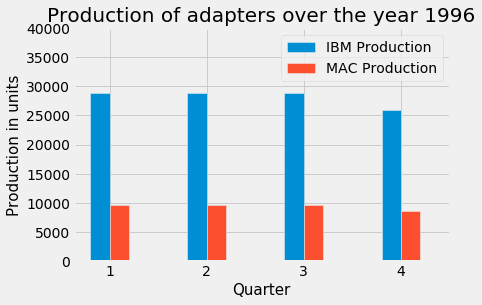

In [10]:
plots.bar(Solution.column("Quarters")-0.1,Solution.column("Production IBM"),width=0.2,label="IBM Production")
plots.bar(Solution.column("Quarters")+0.1,Solution.column("Production Mac"),width=0.2,label="MAC Production")
plots.xticks([1,2,3,4])
plots.axis(xmax=4.5,ymax=40000)
plots.xlabel("Quarter",fontsize=15)
plots.ylabel("Production in units",fontsize=15)
plots.title("Production of adapters over the year 1996",fontsize=20)
_ =plots.legend(loc="upper right")

### Sales in 1996

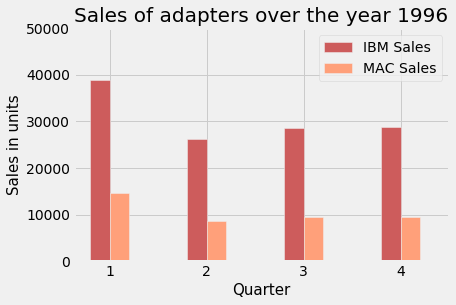

In [11]:
plots.bar(Solution.column("Quarters")-0.1,Solution.column("Sales IBM"),width=0.2,label="IBM Sales", color='indianred')
plots.bar(Solution.column("Quarters")+0.1,Solution.column("Sales Mac"),width=0.2,label="MAC Sales", color='lightsalmon')
plots.xticks([1,2,3,4])
plots.axis(xmax=4.5,ymax=50000)
plots.xlabel("Quarter",fontsize=15)
plots.ylabel("Sales in units",fontsize=15)
plots.title("Sales of adapters over the year 1996",fontsize=20)
_ =plots.legend(loc="upper right")

In [12]:
# Percentage change over time in 1996 for IBM sales
change_in_sales_ibm = make_array((Si[1].x-Si[0].x)/Si[0].x, (Si[2].x-Si[1].x)/Si[1].x, (Si[3].x-Si[2].x)/Si[2].x)*100
Table().with_columns('Quarter', make_array('Q2', 'Q3', 'Q4'), 'Change in Sales IBM', change_in_sales_ibm)

Quarter,Change in Sales IBM
Q2,-32.5211
Q3,9.09091
Q4,0.757576


In [13]:
# Percentage change over time in 1996 for Mac sales
change_in_sales_mac = make_array ((Sm[1].x-Sm[0].x)/Sm[0].x, (Sm[2].x-Sm[1].x)/Sm[1].x, (Sm[3].x-Sm[2].x)/Sm[2].x)*100
Table().with_columns('Quarters', make_array('Q2', 'Q3', 'Q4'), 'Percentage Change in Sales Mac', change_in_sales_mac)

Quarters,Percentage Change in Sales Mac
Q2,-40.2242
Q3,9.09091
Q4,0.757576


### The Effect of Marketing

In [14]:
# Percentage contribution of advertisement to ibm sales for each quarter
# it shows how much adapters sold due to advertisement in percentage
marketing_percentage_ibm = make_array(Mi[0].x/Si[0].x, Mi[1].x/Si[1].x, Mi[2].x/Si[2].x, Mi[3].x/Si[3].x)*100
Table().with_columns('Quarters', make_array('Q1', 'Q2', 'Q3', 'Q4'), 'Marketing Contributions to Sales IBM', marketing_percentage_ibm)

Quarters,Marketing Contributions to Sales IBM
Q1,76.8041
Q2,61.8056
Q3,61.4873
Q4,58.302


In [15]:
# Percentage contribution of advertisement to mac sales for each quarter
# it shows how much adapters sold due to advertisement in percentage
marketing_percentage_mac = make_array(Mm[0].x/Sm[0].x, Mm[1].x/Sm[1].x, Mm[2].x/Sm[2].x, Mm[3].x/Sm[3].x)*100
Table().with_columns('Quarters', make_array('Q1', 'Q2', 'Q3', 'Q4'), 'Marketing Contributions to Sales Mac', marketing_percentage_mac)

Quarters,Marketing Contributions to Sales Mac
Q1,87.6712
Q2,77.0833
Q3,76.8924
Q4,74.9812


Text(0.5, 1.0, 'Sales Contributions IBM')

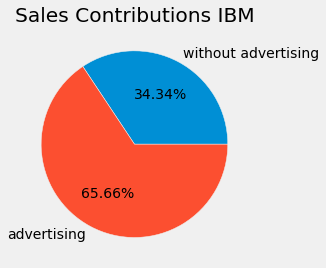

In [16]:
# total sales contribution for ibm in 1996
marketing_total_ibm = Mi[0].x + Mi[1].x + Mi[2].x + Mi[3].x 
sales_raw_total_ibm = Si[0].x + Si[1].x + Si[2].x + Si[3].x - marketing_total_ibm
_ = plots.pie([sales_raw_total_ibm, marketing_total_ibm], labels=['without advertising', 'advertising'], autopct='%1.2f%%')
plots.title("Sales Contributions IBM")

Text(0.5, 1.0, 'Sales Contributions MAC')

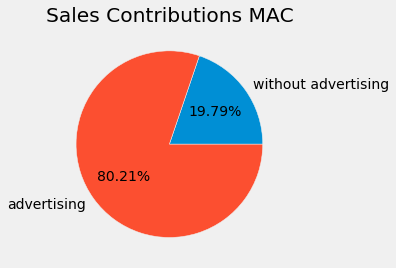

In [17]:
# total sales contribution for mac in 1996
marketing_total_mac = Mm[0].x + Mm[1].x + Mm[2].x + Mm[3].x 
sales_raw_total_mac = Sm[0].x + Sm[1].x + Sm[2].x + Sm[3].x - marketing_total_mac
_ = plots.pie([sales_raw_total_mac, marketing_total_mac], labels=['without advertising', 'advertising'], autopct='%1.2f%%')
plots.title("Sales Contributions MAC")

### Key findings from the optimal solution:

The company can make a maximum profit at about 10,475,777 at the end of year 1996 with all constraints. We should be borrowing the full amount of credit 750,000 every quarter in order to maximize profit. Advertising is important because it contributes a huge part of sales for both IBM and Mac. And there is excess cash flow at the end of every quarter, which is invested in short term government securities to earn interests.

From the graph 'Production in 1996', the production level is relatively stable in 1996. For both IBM and Mac, there is a slight decrease in fourth quarter's production, which is backed by the ending inventory from the third quarter.

According to the graph 'Sales in 1996', we can see a slow down in sales after the first quarter. This might be a result of the company's current cash collection policy. Since the company only collects 75 % of cash everytime it makes a sale and only get $0.5 per adapter for bad debts after 9 months, the cash flow is highly unstable. Longer collection period means less cash is available for contributing to producing, selling, advertising and investing, thus resulting in a lower profit. 

From the effect of marketing tables and pie charts, we can see that the percentage of marketing contributions to sales are very high for both IBM and Mac, around 66% and 80% respectively, thus proving the marketing manager's statement of the importance of keeping the advertising spending of both of the products. 

## Section III: Sensitivity Analysis

Here we study some sensitivity factors and how they impact our original optimal solution in order to have a better understanding of all variables.

### 1. Sensitivity Analysis of Collection Rates (with consulting service and new collection scheme)

#### a) Analyze the effect of this new collection policy and make a recommendation about whether to implement the new procedure. 

In [16]:
def sensitivity_costs(fixed_costs):
    model = Model('case study') # object 
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints

    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=10560)
    
    # cash flow constraint
    # New Collections for IBM for i=1, 2, 3, 4 = 0.90, 0.07, 0.01, 0.02
    # New Collections for IBM for i=1, 2, 3, 4 = 0.92, 0.03, 0.01, 0.04
    
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(0.90*Si[0] + 0.07*8000 + 0.01*7000 + 0.02*7000*0.5) 
                                            + price_mac*(0.92*Sm[0] + 0.03*1600 + 0.01*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + cost_advertising*Mi[0])
                                            - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + cost_advertising*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(0.90*Si[1] + 0.07*Si[0] + 0.01*8000 + 0.02*8000*0.5) 
                                           + price_mac*(0.92*Sm[1] + 0.03*Sm[0] + 0.01*1600 + 0.04*1600*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + cost_advertising*Mi[1]) 
                                           - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + cost_advertising*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(0.90*Si[2] + 0.07*Si[1] + 0.01*Si[0] + 0.02*Si[0]*0.5) 
                                           + price_mac*(0.92*Sm[2] + 0.03*Sm[1] + 0.01*Sm[0] + 0.04*Sm[0]*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + cost_advertising*Mi[2]) 
                                           - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + cost_advertising*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(0.90*Si[3] + 0.07*Si[2] + 0.01*Si[1] + 0.02*Si[1]*0.5) 
                                           + price_mac*(0.92*Sm[3] + 0.07*Sm[2] + 0.01*Sm[1] + 0.04*Sm[1]*0.5)
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + cost_advertising*Mi[3])
                                           - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + cost_advertising*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management constraint ibm
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
    estimated_sale_ibm[1]= model.addConstr(Pi[1] +Ei[1] >= 1.1*Si[2])
    estimated_sale_ibm[2]= model.addConstr(Pi[2] +Ei[2] >= 1.1*Si[3])

    # inventory management constraint mac 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
    estimated_sale_mac[1]= model.addConstr(Pm[1] +Em[1] >= 1.1*Sm[2])
    estimated_sale_mac[2]= model.addConstr(Pm[2] +Em[2] >= 1.1*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])

    
    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before
    
    
    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
           - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
           - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
           - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
           - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
           - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
           - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )
    
    
    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()
    
    # return the optimal profit
    return model.objVal, Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])


In [17]:
model_diff_cost = sensitivity_costs(500000 + 100000/4)[0] # optimal profit when the consulting cost is implememted

sensitivity_costs(500000 + 100000/4)[1]

Optimize a model with 46 rows, 40 columns and 154 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 34 rows, 38 columns, 140 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.0540292e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.04 seconds
Optimal objective  1.054029194e+07
Optimize a model with 46 rows, 40 columns and 154 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 34 rows, 38 columns, 140 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.304

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,4.8009e+06,0,0
2,28800,9600,26181.8,8727.27,16181.8,6727.27,750000,6.47369e+06,2618.18,872.727
3,28800,9600,28562,9520.66,17562,7320.66,750000,8.66771e+06,2856.2,952.066
4,25922.2,8640.72,28778.4,9592.79,16778.4,7192.79,750000,1.13868e+07,0,0


In [110]:
new_strategy_profit = model_diff_cost - base_model
new_strategy_profit

64515.42776942067

In [111]:
(new_strategy_profit) / base_model * 100

0.6158534184043859

After implementing the new collection policy suggested by the consulting company, the optimal profit for American Office Systems, Inc will increase by around 64,515 per year, which is equivalent to a 0.6% increase in total profit. Therefore, we recommend the managers to pursue this new collection policy since it increases the flexibility of the overall cashflow and decreases the incidence of bad debt every 3 quarters. Furthermore, being able to collecting a higher percenage of cash enables the company to invest more excess cash to government bond, thus genrating more interest contributing to the total profit. 

#### b) Howell wonders whether switching to selling adapters for all cash is worth the effort. It would cost about 90,000 more than at present to implement the all-cash policy. Analyze this possibility and make a recommendation to Howell.

In [20]:
def sensitivity_costs(fixed_costs):
    model = Model('case study') # object 
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints

    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=10560)
    
    # cash flow constraint
    # Switching to all cash, no slow collections, no collection agency for accounts that remain unpaid after 9 months
    # we assume the previous collection scheme in 1995 is unchanged, we still collect sales unpaid from 1995
    
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(Si[0] + 0.07*8000 + 0.01*7000 + 0.02*7000*0.5) 
                                            + price_mac*(Sm[0] + 0.03*1600 + 0.01*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + cost_advertising*Mi[0])
                                            - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + cost_advertising*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(Si[1] + 0.01*8000 + 0.02*8000*0.5) 
                                           + price_mac*(Sm[1] + 0.01*1600 + 0.04*1600*0.5)  
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + cost_advertising*Mi[1]) 
                                           - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + cost_advertising*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(Si[2])  
                                           + price_mac*(Sm[2]) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + cost_advertising*Mi[2]) 
                                           - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + cost_advertising*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(Si[3]) 
                                           + price_mac*(Sm[3]) 
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + cost_advertising*Mi[3])
                                           - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + cost_advertising*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management constraint ibm
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
    estimated_sale_ibm[1]= model.addConstr(Pi[1] +Ei[1] >= 1.1*Si[2])
    estimated_sale_ibm[2]= model.addConstr(Pi[2] +Ei[2] >= 1.1*Si[3])

    # inventory management constraint mac 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
    estimated_sale_mac[1]= model.addConstr(Pm[1] +Em[1] >= 1.1*Sm[2])
    estimated_sale_mac[2]= model.addConstr(Pm[2] +Em[2] >= 1.1*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])

    
    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before
    
    
    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
           - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
           - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
           - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
           - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
           - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
           - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )
    
    
    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()
    
    # return the optimal profit
    return model.objVal, Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])

In [21]:
model_all_cash = sensitivity_costs(500000 + 90000/4)[0] # optimal profit when all cash policy is implemented
sensitivity_costs(500000 + 90000/4)[1]

Optimize a model with 46 rows, 40 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 34 rows, 38 columns, 130 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      18    1.0725507e+07   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.02 seconds
Optimal objective  1.072550739e+07
Optimize a model with 46 rows, 40 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 34 rows, 38 columns, 130 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.304

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,5.716e+06,0,0
2,28800,9600,26181.8,8727.27,16181.8,6727.27,750000,7.43994e+06,2618.18,872.727
3,28800,9600,28562,9520.66,17562,7320.66,750000,9.70663e+06,2856.2,952.066
4,25922.2,8640.72,28778.4,9592.79,16778.4,7192.79,750000,1.24737e+07,0,0


In [22]:
model_all_cash - base_model

249730.8726111576

In [23]:
(model_all_cash - base_model) / base_model *100

2.383888891326384

After implementing the all cash policy, the optimal profit for American Office Systems, Inc will increase by around  249,731 per year, which is equivalent to a 2.4% increase in total profit. Since the 90,000 training cost is compensated by an overall increase in profit, we recommend the managers to pursue this new collection policy since it  ameliorates the cash squeeze because it would eliminate not only the slow collections but also the loss of cash from using the collection agency for accounts that remain unpaid after 9 months. Once again, being able to collect a higher percenage of cash enables the company to invest more excess cash to government bond or company development, thus genrating more interest contributing to the total profit.

### 2. Sensitivity Analysis of Safety Cushion (for inventory shortage of adapters)

In [24]:
# Sensitivity Analysis of saftey cushion for inventory shortage of adapters
# Safety cushion is presented in percentage form


def sensitivity_inventory(safety_cushion):
    model = Model('case study')
    
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints

    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=10560)


    # cash flow constraint
    # cash inflows contain borrowing, sales of ibm and mac
    # cash outflows include fixed costs, variable costs, inventory holding costs, and advertising costs
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                            + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + cost_advertising*Mi[0])
                                            - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + cost_advertising*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                           + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + cost_advertising*Mi[1]) 
                                           - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + cost_advertising*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                           + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + cost_advertising*Mi[2]) 
                                           - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + cost_advertising*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                           + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5)
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + cost_advertising*Mi[3])
                                           - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + cost_advertising*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management ibm constraint
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= (1+safety_cushion)*Si[1]) # safety cushion
    estimated_sale_ibm[1]=model.addConstr(Pi[1] + Ei[1] >= (1+safety_cushion)*Si[2])
    estimated_sale_ibm[2]=model.addConstr(Pi[2] + Ei[2] >= (1+safety_cushion)*Si[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_ibm[3]=model.addConstr(Pi[3] + Ei[3] >= 2*12000)

    # inventory management mac constraint 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= (1+safety_cushion)*Sm[1]) # safety cushion
    estimated_sale_mac[1]=model.addConstr(Pm[1] + Em[1] >= (1+safety_cushion)*Sm[2])
    estimated_sale_mac[2]=model.addConstr(Pm[2] + Em[2] >= (1+safety_cushion)*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_mac[3]=model.addConstr(Pm[3] + Em[3] >= 2*2400)

    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])

    
    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before

    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
           - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
           - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
           - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
           - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
           - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
           - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )

    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()
    
    # return the optimal profit
    return model.objVal, Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])

In [25]:
sc_15 = sensitivity_inventory(0.15)[0] # optimal profit when safety cushion is changed to 15%
sensitivity_inventory(0.15)[1]  # table of variables under optimal solution

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.04s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.0307597e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.05 seconds
Optimal objective  1.030759663e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.304

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,3.7003e+06,0,0
2,28800,9600,25043.5,8347.83,15043.5,6347.83,750000,5.44235e+06,3756.52,1252.17
3,28800,9600,28310,9436.67,17310,7236.67,750000,7.55848e+06,4246.5,1415.5
4,24489.6,8163.2,28736.1,9578.7,16736.1,7178.7,750000,1.03523e+07,0,0


#### a. Suppose that Garcia finds a bug in his original inventory model. Correcting it results in a safety cushion of 15% instead of the 10% he suggested previously. Determine whether this is important.

In [26]:
sc_15 - base_model

-168179.88714015484

In [27]:
(sc_15 - base_model) / base_model * 100

-1.6054169054308085

The optimal profit decreases with a safety cushion of 15%. It just provides more certainty of low change of shortage for next quarter. As the safety cushion increases, the sum of production of current quarter and the ending inventory from last quarter has a higher minimum constraint. If we compare two tables of decision variables, we can see that there is an increase in ending inventory, which means an increase in the inventory carrying cost. Also, the sales for IMB adapters decrease a little bit. Those are the two major reasons of lower profit. It is important to determine the right inventory model because the decrease of 168,180 is about a 1.61% decrease in profit after changing.

#### b. What if the error is 20%? Explain the answers in terms that Miller will understand.

In [28]:
sc_20 = sensitivity_inventory(0.2)[0] # optimal profit when safety cushion is changed to 15%
sensitivity_inventory(0.2)[1] # table of variables under optimal solution

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      23    1.0141083e+07   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.02 seconds
Optimal objective  1.014108304e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.304

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,3.7003e+06,0,0
2,28800,9600,24000,8000,14000,6000,750000,5.25937e+06,4800,1600
3,28800,9600,28000,9333.33,17000,7133.33,750000,7.26995e+06,5600,1866.67
4,23533.3,7688.89,28666.7,9555.56,16666.7,7155.56,750000,1.01686e+07,466.667,0


In [29]:
sc_20 - base_model

-334693.4746506363

In [30]:
(sc_20 - base_model) / base_model * 100

-3.194927594961012

The optimal profit decreases with a safety cushion of 20%. It just provides even more certainty of low change of shortage for next quarter. The decrease of 334,693 is about a 3.19% decrease in profit after changing. From the table, we can see that the ending inventory of both IBM and Mac is about two times the inventory of that with a safety cushion of 10%, which doubles the inventory carrying cost. In addition, sales of IBM and Mac decrease a little bit respectively.

#### c. Overall sensitivity test of inventory safety cushion

In [31]:
scale_factor_sc = np.arange(-1, 1, 0.05)
scale_factor_sc
objs_sc = np.zeros(len(scale_factor_sc))

for i in np.arange(len(scale_factor_sc)):
    safety_cushion = scale_factor_sc[i]
    objs_sc[i] = sensitivity_inventory(safety_cushion)[0]

objs_sc

Optimize a model with 48 rows, 40 columns and 152 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 18 rows and 2 columns
Presolve time: 0.02s
Presolved: 30 rows, 38 columns, 126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      12    1.1077412e+07   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.03 seconds
Optimal objective  1.107741175e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.304


Solved in 16 iterations and 0.02 seconds
Optimal objective  1.107741175e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [7e-01, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      16    1.1077412e+07   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.02 seconds
Optimal objective  1.107741175e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [8e-01, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iter

      23    9.6601284e+06   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.02 seconds
Optimal objective  9.660128428e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      23    9.5072976e+06   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.02 seconds
Optimal objective  9.507297645e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolv

array([11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 11077411.75192545, 11077411.75192545,
       11077411.75192545, 10955655.96245177, 10820371.75192545,
       10646770.24237443, 10475776.51457608, 10307596.62743592,
       10141083.03992545,  9977165.26552545,  9816791.17937014,
        9660128.42763464,  9507297.64505664,  9358375.67636811,
        9213400.72792545,  9071975.34041486,  8934203.02492545,
        8800333.26460864,  8670304.48828693,  8544041.34730737,
        8421458.05078964,  8302461.14891564,  8186951.83069378,
        8074827.80329974])

Text(0.5, 1.0, 'Sensitivity Analysis of Safety Cushion')

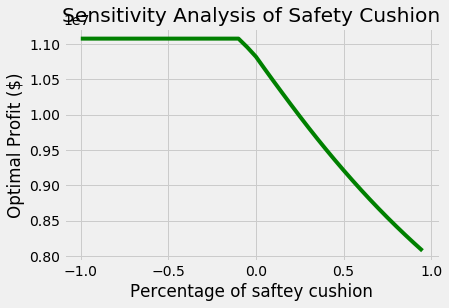

In [32]:
plots.plot(scale_factor_sc, objs_sc, 'g')
plots.xlabel('Percentage of saftey cushion')
plots.ylabel('Optimal Profit ($)')
plots.title('Sensitivity Analysis of Safety Cushion')

From the graph, we can see that from when we have no constraints on inventory level to when we keep about 90% of next quarter estimated sales, we would be able to generate about 600,000 more in profit. As we increase our safety cushion, the optimal profit starts to decrease rapidly. This implies that a low saftey cushion or even a negative one can bring more profit to our firm.

### 3. Sensitivity Analysis of Production Capacity

Here we want to assess the impact of the fourth quarter production level on the overall profit. It is anticipated that after the warehouse completion, capacity in Q4 will increase by 10%. When it is not the case however and something happens such as a delay in construction like we often see in Montreal or an accident that actually decrease that Q4 capacity. The capaycity is subject to change.

In [33]:
# Production capacity is presented in percentage form
# we assume the production capacity change in same percentage for ibm and mac

# Function that takes as input the production capacity percentage change
def sensitivity_production(percentage_change_production_q4):
    model = Model('case study')
    
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints

    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=28800 * (1 + percentage_change_production_q4))# production constraint of the sensitivity analysis

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=9600 - (1 + percentage_change_production_q4))# production constraint of the sensitivity analysis


    # cash flow constraint
    # cash inflows contain borrowing, sales of ibm and mac
    # cash outflows include fixed costs, variable costs, inventory holding costs, and advertising costs
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                            + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + cost_advertising*Mi[0])
                                            - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + cost_advertising*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                           + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + cost_advertising*Mi[1]) 
                                           - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + cost_advertising*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                           + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + cost_advertising*Mi[2]) 
                                           - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + cost_advertising*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                           + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5)
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + cost_advertising*Mi[3])
                                           - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + cost_advertising*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management ibm constraint
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
    estimated_sale_ibm[1]=model.addConstr(Pi[1] + Ei[1] >= 1.1*Si[2])
    estimated_sale_ibm[2]=model.addConstr(Pi[2] + Ei[2] >= 1.1*Si[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_ibm[3]=model.addConstr(Pi[3] + Ei[3] >= 2*12000)

    # inventory management mac constraint 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
    estimated_sale_mac[1]=model.addConstr(Pm[1] + Em[1] >= 1.1*Sm[2])
    estimated_sale_mac[2]=model.addConstr(Pm[2] + Em[2] >= 1.1*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_mac[3]=model.addConstr(Pm[3] + Em[3] >= 2*2400)

    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])
    

    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before

    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
           - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
           - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
           - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
           - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
           - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
           - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )

    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()
    
    # store the optimal profit with the new Q4 capacity
    prod_constraint_model= model.ObjVal
    print("The optimal solution will result in a profit of:", "$",prod_constraint_model, "at the end of Q4 1996") 

    Solution = Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])
    
    return prod_constraint_model, Solution

#### a) Suppose that Miller is advised by the construction company that the work will not be finished until the following year. How will this delay affect the company’s plans?

In [34]:
# setting the percentage change to 0 as input
new_profit_noproduction_change = sensitivity_production(0)[0]

print("Here is a table containing key summary information regarding the optimal solution:")
sensitivity_production(0)[1]

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.0475777e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.02 seconds
Optimal objective  1.047577651e+07
The optimal solution will result in a profit of: $ 10475776.514576087 at the end of Q4 1996
Here is a table containing key summary information regarding the optimal solution:
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve rem

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,3.7003e+06,0,0
2,28800,9600,26181.8,8727.27,16181.8,6727.27,750000,5.64195e+06,2618.18,872.727
3,28800,9600,28562,9520.66,17562,7320.66,750000,7.85813e+06,2856.2,952.066
4,25922.2,8640.72,28778.4,9592.79,16778.4,7192.79,750000,1.04918e+07,0,0


In [35]:
# the percentage change in profit from the original model
percent_change_from_initial_optimal_solution = (new_profit_noproduction_change - base_model)/base_model
print('Given that the work will not be finished until the following year, the percentage profit percentage change from the original optimal solution profit is ' 
      + str(percent_change_from_initial_optimal_solution) + '%.')
        
      

Given that the work will not be finished until the following year, the percentage profit percentage change from the original optimal solution profit is 0.0%.


#### b) In addition to the delay in part a, suppose that an accident in the production facility damages some of the equipment so that the capacity is decreased by 10% in the fourth quarter. Analyze how this will affect the original solution.

In [36]:
# capacity change of -10% from previous quarters
new_profit_negative_production_change = sensitivity_production(-.1)[0]

print("Here is a table containing key summary information regarding the optimal solution:")
sensitivity_production(-.1)[1]

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      21    1.0475640e+07   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.03 seconds
Optimal objective  1.047563966e+07
The optimal solution will result in a profit of: $ 10475639.655071955 at the end of Q4 1996
Here is a table containing key summary information regarding the optimal solution:
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve rem

Quarters,Production IBM,Production Mac,Sales IBM,Sales Mac,Marketing IBM,Marketing Mac,Amount borrowed,Cash flow,Ending inventory IBM,Ending inventory Mac
1,28800,9600,38800,14600,29800,12800,750000,3.7003e+06,0,0
2,28800,9600,26181.8,8727.27,16181.8,6727.27,750000,5.64195e+06,2618.18,872.727
3,28800,9600,28562,9520.66,17562,7320.66,750000,7.85813e+06,2856.2,952.066
4,25920,8640.72,28776.2,9592.79,16776.2,7192.79,750000,1.04918e+07,0,0


In [37]:
percent_change_from_initial_optimal_solution2 = (new_profit_negative_production_change - base_model)/base_model
print('Given that an accident in the production facility damages some of the equipment so that the capacity is decreased by 10% in the fourth quarter, the percentage profit change from the original optimal solution profit is ' 
      + str(round(percent_change_from_initial_optimal_solution2*100,4)) + '%, or ' + str(round(new_profit_negative_production_change-base_model,2)) + '$.')
      
      

Given that an accident in the production facility damages some of the equipment so that the capacity is decreased by 10% in the fourth quarter, the percentage profit change from the original optimal solution profit is -0.0013%, or -136.86$.


#### c) overall sensitivity of the fourth quarter production 

In [38]:
# all possible outcomes rangeing from a decrease of 100% to an increase of 100%

scale_factor_prod = np.arange(-1, 1, 0.10)
scale_factor_prod
objs_prod = np.zeros(len(scale_factor_prod))

for i in np.arange(len(scale_factor_prod)):
    fourth_quarter_change = scale_factor_prod[i]
    objs_prod[i] = sensitivity_production(fourth_quarter_change)[0]

objs_prod

Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 15 rows and 4 columns
Presolve time: 0.02s
Presolved: 33 rows, 36 columns, 136 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      21    6.8671739e+06   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.02 seconds
Optimal objective  6.867173936e+06
The optimal solution will result in a profit of: $ 6867173.93606369 at the end of Q4 1996
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 14 rows and 4 columns
Presolve time: 0.02s
Presolved: 34 rows, 36 columns, 143 n

Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.0475777e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.02 seconds
Optimal objective  1.047577651e+07
The optimal solution will result in a profit of: $ 10475776.514576087 at the end of Q4 1996
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual

array([ 6867173.93606369,  7338322.00879096,  7771502.80879097,
        8204683.60879096,  8637001.63854303,  9067561.63854303,
        9483959.65507196,  9856919.65507196, 10229879.65507196,
       10475639.65507196, 10475776.51457609, 10475776.51457609,
       10475776.51457609, 10475776.51457609, 10475776.51457609,
       10475776.51457609, 10475776.51457609, 10475776.51457609,
       10475776.51457609, 10475776.51457609])

In [39]:
# Creating a table with all outcomes 
production_table = Table().with_columns('Production Change',scale_factor_prod, 'Profit', objs_prod, 'Amount difference', objs_prod - base_model)
# 'Amount difference' is the difference in profit from the inital senario (wharehouse construction completed and no accident)
production_table

Production Change,Profit,Amount difference
-1,6.86717e+06,-3.6086e+06
-0.9,7.33832e+06,-3.13745e+06
-0.8,7.7715e+06,-2.70427e+06
-0.7,8.20468e+06,-2.27109e+06
-0.6,8.637e+06,-1.83877e+06
-0.5,9.06756e+06,-1.40821e+06
-0.4,9.48396e+06,-991817
-0.3,9.85692e+06,-618857
-0.2,1.02299e+07,-245897
-0.1,1.04756e+07,-136.86


Text(0.5, 1.0, 'Sensitivity Analysis of Q4 Production Capacity')

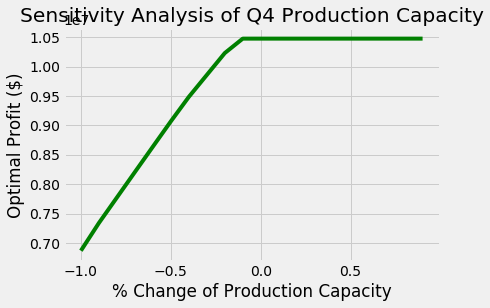

In [40]:
plots.plot(scale_factor_prod ,objs_prod, 'g')
plots.xlabel('% Change of Production Capacity')
plots.ylabel('Optimal Profit ($)')
plots.title('Sensitivity Analysis of Q4 Production Capacity')


In [41]:
# find the value of production change for which profit is lower than the original optimal profit
production_table.where('Amount difference', are.below(0))

Production Change,Profit,Amount difference
-1,6.86717e+06,-3.6086e+06
-0.9,7.33832e+06,-3.13745e+06
-0.8,7.7715e+06,-2.70427e+06
-0.7,8.20468e+06,-2.27109e+06
-0.6,8.637e+06,-1.83877e+06
-0.5,9.06756e+06,-1.40821e+06
-0.4,9.48396e+06,-991817
-0.3,9.85692e+06,-618857
-0.2,1.02299e+07,-245897
-0.1,1.04756e+07,-136.86


From the results above we understand that an increase in production capacity from the third quarter to the fourth quarter will never increase profit as a plateau is reached at a specific capacity due to demand constraitns. From the table above, we see that the specific percentage reduction is around -10%, for which every value below decrease the optimal profit from the plateau. This mean that ideally we would like to produce, during the fourth quarter, an amount equivalent to the third quarter production with a percentage change just above -10%. 

## Section IV: Original Sensitivity Analysis

Here we present two original sensitivity analysis of our interest.

## 1. Sensitivity Analysis of Advertising Cost

In [42]:
# Sensitivity Analysis of advertising costs

def sensitivity_advertising(advertising_cost):
    model = Model('case study')
    
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints

    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=10560)


    # cash flow constraint
    # cash inflows contain borrowing, sales of ibm and mac
    # cash outflows include fixed costs, variable costs, inventory holding costs, and advertising costs
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                            + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*Pi[0] + inventory_holding_cost*VC_ibm*Ei[0] + advertising_cost*Mi[0])
                                            - (VC_mac*Pm[0] + inventory_holding_cost*VC_mac*Em[0] + advertising_cost*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                           + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*Pi[1] + inventory_holding_cost*VC_ibm*Ei[1] + advertising_cost*Mi[1]) 
                                           - (VC_mac*Pm[1] + inventory_holding_cost*VC_mac*Em[1] + advertising_cost*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                           + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*Pi[2] + inventory_holding_cost*VC_ibm*Ei[2] + advertising_cost*Mi[2]) 
                                           - (VC_mac*Pm[2] + inventory_holding_cost*VC_mac*Em[2] + advertising_cost*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                           + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5)
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*Pi[3] + inventory_holding_cost*VC_ibm*Ei[3] + advertising_cost*Mi[3])
                                           - (VC_mac*Pm[3] + inventory_holding_cost*VC_mac*Em[3] + advertising_cost*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management ibm constraint
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
    estimated_sale_ibm[1]=model.addConstr(Pi[1] + Ei[1] >= 1.1*Si[2])
    estimated_sale_ibm[2]=model.addConstr(Pi[2] + Ei[2] >= 1.1*Si[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_ibm[3]=model.addConstr(Pi[3] + Ei[3] >= 2*12000)

    # inventory management mac constraint 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
    estimated_sale_mac[1]=model.addConstr(Pm[1] + Em[1] >= 1.1*Sm[2])
    estimated_sale_mac[2]=model.addConstr(Pm[2] + Em[2] >= 1.1*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_mac[3]=model.addConstr(Pm[3] + Em[3] >= 2*2400)

    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])
    

    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before

    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*Si[0]-VC_mac*Sm[0]-VC_ibm*Si[1]-VC_mac*Sm[1]-VC_ibm*Si[2]-VC_mac*Sm[2]-VC_ibm*Si[3]-VC_mac*Sm[3]
           - inventory_holding_cost*(VC_ibm*Ei[0]+VC_mac*Em[0])
           - inventory_holding_cost*(VC_ibm*Ei[1]+VC_mac*Em[1])
           - inventory_holding_cost*(VC_ibm*Ei[2]+VC_mac*Em[2])
           - inventory_holding_cost*(VC_ibm*Ei[3]+VC_mac*Em[3])
           - advertising_cost*(Mi[0]+Mm[0])-advertising_cost*(Mi[1]+Mm[1])
           - advertising_cost*(Mi[2]+Mm[2])-advertising_cost*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )

    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()
    
    # return the optimal profit
    return model.objVal

In [43]:
scale_factor_ad = np.arange(0, 200, 5)
scale_factor_ad
objs_ad = np.zeros(len(scale_factor_ad))

for i in np.arange(len(scale_factor_ad)):
    advertising_cost = scale_factor_ad[i]
    objs_ad[i] = sensitivity_advertising(advertising_cost)

objs_ad

Optimize a model with 48 rows, 40 columns and 150 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 20 rows and 10 columns
Presolve time: 0.01s
Presolved: 28 rows, 30 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    1.1739868e+07   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.03 seconds
Optimal objective  1.173986799e+07
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.30


Solved in 18 iterations and 0.03 seconds
Optimal objective  3.523273379e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1520000e+31   5.150000e+29   1.152000e+01      0s
      20    2.9110433e+06   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.02 seconds
Optimal objective  2.911043310e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iter

      13    2.0420068e+06   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.03 seconds
Optimal objective  2.042006816e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1520000e+31   5.150000e+29   1.152000e+01      0s
      13    2.0420068e+06   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds
Optimal objective  2.042006816e+06
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolv

array([11739867.99375039, 11107822.25416324, 10475776.51457609,
        9843730.77498894,  9211685.03540178,  8579639.29581463,
        7947593.55622748,  7315547.81664032,  6683502.07705317,
        6051456.33746602,  5419410.59787887,  4787364.85829171,
        4155319.11870456,  3523273.37911741,  2911043.30967301,
        2541635.67076908,  2311827.1102473 ,  2133786.96582055,
        2070922.57835045,  2049122.93284045,  2043209.36534045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045,  2042006.81579045,  2042006.81579045,
        2042006.81579045])

Text(0.5, 1.0, 'Sensitivity Analysis of Advertising Cost')

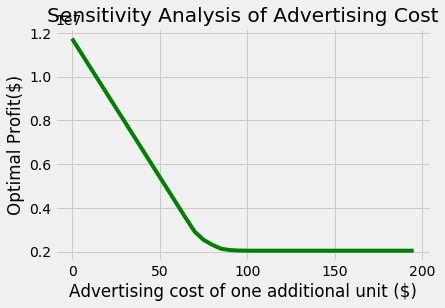

In [44]:
plots.plot(scale_factor_ad, objs_ad, 'g')
plots.xlabel('Advertising cost of one additional unit ($)')
plots.ylabel('Optimal Profit($)')
plots.title('Sensitivity Analysis of Advertising Cost')

As the advertising cost for one additional unit sold, the optimal profit increases. The profit is maximum when the advertising cost is 0. The optimal profit reaches a plateau of 8,500,000 when the advertising cost is around 90 and it doesn't decrease even if the advertising cost increases. It is important for the company to try to keep the adevertising cost for selling one more unit as low as possible.

## 2. Sensitivity Analysis of Variable Costs

In [45]:
# cost_change stores the percentage change of the variable cost of each product.

# construct a function taking as input the %change in variable costs of each adapter
# in the function we then adjust VC of the initial model to be VC*(1+cost_change)

def sensitivity_prices(cost_change):
    model = Model('case study')
    
    # initilizing empty dictionaries
    Pi = {}  
    Pm = {} 
    Si = {} 
    Sm = {} 
    Mi = {} 
    Mm = {} 
    B = {} 
    Ei = {}
    Em = {} 
    CF={}

    # create decisions variable
    for i in np.arange(4):  
        Pi[i] = model.addVar(lb=0)
        Pm[i] = model.addVar(lb=0)
        Si[i] = model.addVar(lb=0)
        Sm[i] = model.addVar(lb=0)
        Mi[i] = model.addVar(lb=0)
        Mm[i] = model.addVar(lb=0)
        B[i] = model.addVar(lb=0)
        CF[i] = model.addVar(lb=0)
        Ei[i] = model.addVar(lb=0)
        Em[i] = model.addVar(lb=0)
    
    
    # Creating Constraints
    # production ibm constraint
    con_production_ibm={}
    con_production_ibm[0]= model.addConstr(Pi[0]<=28800)
    con_production_ibm[1]= model.addConstr(Pi[1]<=28800)
    con_production_ibm[2]= model.addConstr(Pi[2]<=28800)
    con_production_ibm[3]= model.addConstr(Pi[3]<=31680)

    # production mac constraint
    con_production_mac={}
    con_production_mac[0]=model.addConstr(Pm[0]<=9600)
    con_production_mac[1]=model.addConstr(Pm[1]<=9600)
    con_production_mac[2]=model.addConstr(Pm[2]<=9600)
    con_production_mac[3]=model.addConstr(Pm[3]<=10560)

    # cash flow constraint
    # cash inflows contain borrowing, sales of ibm and mac
    # cash outflows include fixed costs, variable costs, inventory holding costs, and advertising costs
    cash_flow={}
    cash_flow[0]=model.addConstr(CF[0] == (B[0] 
                                            + price_ibm*(0.75*Si[0] + 0.20*8000 + 0.03*7000 + 0.02*7000*0.5) 
                                            + price_mac*(0.80*Sm[0] + 0.11*1600 + 0.05*1400 + 0.04*1400*0.5) 
                                            - (VC_ibm*(1+cost_change)*Pi[0] + inventory_holding_cost*VC_ibm*(1+cost_change)*Ei[0] + cost_advertising*Mi[0])
                                            - (VC_mac*(1+cost_change)*Pm[0] + inventory_holding_cost*VC_mac*(1+cost_change)*Em[0] + cost_advertising*Mm[0]) 
                                            - fixed_costs))
    cash_flow[1]=model.addConstr(CF[1] == ((B[1]-B[0]) 
                                           + price_ibm*(0.75*Si[1] + 0.20*Si[0] + 0.03*8000 + 0.02*8000*0.5) 
                                           + price_mac*(0.80*Sm[1] + 0.11*Sm[0] + 0.05*1600 + 0.04*1600*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[0]
                                           - (VC_ibm*(1+cost_change)*Pi[1] + inventory_holding_cost*VC_ibm*(1+cost_change)*Ei[1] + cost_advertising*Mi[1]) 
                                           - (VC_mac*(1+cost_change)*Pm[1] + inventory_holding_cost*VC_mac*(1+cost_change)*Em[1] + cost_advertising*Mm[1]) 
                                           - B[0]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[2]=model.addConstr(CF[2] == ((B[2]-B[1]) 
                                           + price_ibm*(0.75*Si[2] + 0.20*Si[1] + 0.03*Si[0] + 0.02*Si[0]*0.5) 
                                           + price_mac*(0.80*Sm[2] + 0.11*Sm[1] + 0.05*Sm[0] + 0.04*Sm[0]*0.5) 
                                           + (1+interest_rate_bonds/4)*CF[1]
                                           - (VC_ibm*(1+cost_change)*Pi[2] + inventory_holding_cost*VC_ibm*(1+cost_change)*Ei[2] + cost_advertising*Mi[2]) 
                                           - (VC_mac*(1+cost_change)*Pm[2] + inventory_holding_cost*VC_mac*(1+cost_change)*Em[2] + cost_advertising*Mm[2]) 
                                           - B[1]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))
    cash_flow[3]=model.addConstr(CF[3] == ((B[3]-B[2]) 
                                           + price_ibm*(0.75*Si[3] + 0.20*Si[2] + 0.03*Si[1] + 0.02*Si[1]*0.5) 
                                           + price_mac*(0.80*Sm[3] + 0.11*Sm[2] + 0.05*Sm[1] + 0.04*Sm[1]*0.5)
                                           + (1+interest_rate_bonds/4)*CF[2]
                                           - (VC_ibm*(1+cost_change)*Pi[3] + inventory_holding_cost*VC_ibm*(1+cost_change)*Ei[3] + cost_advertising*Mi[3])
                                           - (VC_mac*(1+cost_change)*Pm[3] + inventory_holding_cost*VC_mac*(1+cost_change)*Em[3] + cost_advertising*Mm[3]) 
                                           - B[2]*((1+interest_rate_LOC)**(0.25)-1) 
                                           - fixed_costs))


    # inventory management ibm constraint
    estimated_sale_ibm={}
    estimated_sale_ibm[0]=model.addConstr(Pi[0] + Ei[0] >= 1.1*Si[1])
    estimated_sale_ibm[1]=model.addConstr(Pi[1] + Ei[1] >= 1.1*Si[2])
    estimated_sale_ibm[2]=model.addConstr(Pi[2] + Ei[2] >= 1.1*Si[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_ibm[3]=model.addConstr(Pi[3] + Ei[3] >= 2*12000)

    # inventory management mac constraint 
    estimated_sale_mac={}
    estimated_sale_mac[0]=model.addConstr(Pm[0] + Em[0] >= 1.1*Sm[1])
    estimated_sale_mac[1]=model.addConstr(Pm[1] + Em[1] >= 1.1*Sm[2])
    estimated_sale_mac[2]=model.addConstr(Pm[2] + Em[2] >= 1.1*Sm[3])
    # The inventory level plus production at the end of the fourth quarter of 1996 should be at least twice the maximum expected sales for that quarter. 
    estimated_sale_mac[3]=model.addConstr(Pm[3] + Em[3] >= 2*2400)

    
    # availability after production ibm constraint 
    availability_ibm={}
    availability_ibm[0]=model.addConstr(Pi[0] + beginning_inventory_ibm >= Si[0])
    availability_ibm[1]=model.addConstr(Pi[1] + Ei[0] >= Si[1])
    availability_ibm[2]=model.addConstr(Pi[2] + Ei[1] >= Si[2])
    availability_ibm[3]=model.addConstr(Pi[3] + Ei[2] >= Si[3])

    # availability after production mac constraint 
    availability_mac={}
    availability_mac[0]=model.addConstr(Pm[0] + beginning_inventory_mac >= Sm[0])
    availability_mac[1]=model.addConstr(Pm[1] + Em[0] >= Sm[1])
    availability_mac[2]=model.addConstr(Pm[2] + Em[1] >= Sm[2])
    availability_mac[3]=model.addConstr(Pm[3] + Em[2] >= Sm[3])
    

    # ending inventory ibm constraint
    ending_inventory_ibm={}
    ending_inventory_ibm[0]=model.addConstr(Ei[0] == beginning_inventory_ibm + Pi[0] - Si[0])
    ending_inventory_ibm[1]=model.addConstr(Ei[1] == Ei[0] + Pi[1] - Si[1])
    ending_inventory_ibm[2]=model.addConstr(Ei[2] == Ei[1] + Pi[2] - Si[2])
    ending_inventory_ibm[3]=model.addConstr(Ei[3] == Ei[2] + Pi[3] - Si[3])

    # ending inventory mac constraint
    ending_inventory_mac={}
    ending_inventory_mac[0]=model.addConstr(Em[0] == beginning_inventory_mac + Pm[0] - Sm[0])
    ending_inventory_mac[1]=model.addConstr(Em[1] == Em[0] + Pm[1] - Sm[1])
    ending_inventory_mac[2]=model.addConstr(Em[2] == Em[1] + Pm[2] - Sm[2])
    ending_inventory_mac[3]=model.addConstr(Em[3] == Em[2] + Pm[3] - Sm[3])


    # sales limits ibm constraint
    actual_sale_ibm={}
    actual_sale_ibm[0]=model.addConstr(Si[0] <= 9000 + Mi[0])
    actual_sale_ibm[1]=model.addConstr(Si[1] <= 10000 + Mi[1])
    actual_sale_ibm[2]=model.addConstr(Si[2] <= 11000 + Mi[2])
    actual_sale_ibm[3]=model.addConstr(Si[3] <= 12000 + Mi[3])

    # sales limits mac constraint
    actual_sale_mac={}
    actual_sale_mac[0]=model.addConstr(Sm[0] <= 1800 + Mm[0])
    actual_sale_mac[1]=model.addConstr(Sm[1] <= 2000 + Mm[1])
    actual_sale_mac[2]=model.addConstr(Sm[2] <= 2200 + Mm[2])
    actual_sale_mac[3]=model.addConstr(Sm[3] <= 2400 + Mm[3])

    # borrowing/line of credit constraint
    borrowing_cost={}
    borrowing_cost[0]=model.addConstr(B[0] <= 750000)
    borrowing_cost[1]=model.addConstr(B[1] <= 750000)
    borrowing_cost[2]=model.addConstr(B[2] <= 750000)
    borrowing_cost[3]=model.addConstr(B[3] <= 750000)


    # all the decision variables should be positive
    # the lower bound is 0 as defined before

    # objective function
    # the profit at the end of Q4 1996 does not include the interest rate of borrowing in Q4 and interest rate earned on excess cash flows in Q4

    obj = (  price_ibm*(1-0.02*0.5)*Si[0]+price_mac*(1-0.02*0.5)*Sm[0]
           + price_ibm*(1-0.02*0.5)*Si[1]+price_mac*(1-0.02*0.5)*Sm[1]
           + price_ibm*(1-0.02*0.5)*Si[2]+price_mac*(1-0.02*0.5)*Sm[2]
           + price_ibm*(1-0.02*0.5)*Si[3]+price_mac*(1-0.02*0.5)*Sm[3]
           + interest_rate_bonds*(CF[0]+CF[1]+CF[2])
           - fixed_costs*4 
           - VC_ibm*(1+cost_change)*Si[0]-VC_mac*(1+cost_change)*Sm[0]
           - VC_ibm*(1+cost_change)*Si[1]-VC_mac*(1+cost_change)*Sm[1]
           - VC_ibm*(1+cost_change)*Si[2]-VC_mac*(1+cost_change)*Sm[2]
           - VC_ibm*(1+cost_change)*Si[3]-VC_mac*(1+cost_change)*Sm[3]
           - inventory_holding_cost*(VC_ibm*(1+cost_change)*Ei[0]+VC_mac*(1+cost_change)*Em[0])
           - inventory_holding_cost*(VC_ibm*(1+cost_change)*Ei[1]+VC_mac*(1+cost_change)*Em[1])
           - inventory_holding_cost*(VC_ibm*(1+cost_change)*Ei[2]+VC_mac*(1+cost_change)*Em[2])
           - inventory_holding_cost*(VC_ibm*(1+cost_change)*Ei[3]+VC_mac*(1+cost_change)*Em[3])
           - cost_advertising*(Mi[0]+Mm[0])-cost_advertising*(Mi[1]+Mm[1])
           - cost_advertising*(Mi[2]+Mm[2])-cost_advertising*(Mi[3]+Mm[3])
           - ((1+interest_rate_LOC)**(0.25)-1)*(B[0]+B[1]+B[2]) )

    # the objective is to maximize the profit at the end of Q4 1996
    model.setObjective(obj, GRB.MAXIMIZE)
    
    model.optimize()

  # store the optimal profit 
    vc_change_model= model.ObjVal
    print("The optimal solution will result in a profit of:", "$",vc_change_model, "at the end of Q4 1996") 

    Solution = Table().with_columns([
     'Quarters',[1,2,3,4],
    'Production IBM',[Pi[0].x, Pi[1].x,Pi[2].x,Pi[3].x],
    'Production Mac',[Pm[0].x, Pm[1].x,Pm[2].x,Pm[3].x],
    'Sales IBM',[Si[0].x, Si[1].x,Si[2].x,Si[3].x],
    'Sales Mac',[Sm[0].x, Sm[1].x,Sm[2].x,Sm[3].x],
    'Marketing IBM',[Mi[0].x, Mi[1].x,Mi[2].x,Mi[3].x],
    'Marketing Mac',[Mm[0].x, Mm[1].x,Mm[2].x,Mm[3].x],
    'Amount borrowed',[B[0].x, B[1].x,B[2].x,B[3].x],
    'Cash flow',[CF[0].x, CF[1].x,CF[2].x,CF[3].x],
    'Ending inventory IBM',[Ei[0].x, Ei[1].x,Ei[2].x,Ei[3].x],
    'Ending inventory Mac',[Em[0].x, Em[1].x,Em[2].x,Em[3].x],     
    ])
    
    return vc_change_model,Solution


In [101]:
# Input range from a 100% cost decrease (we get the product for free) to a 100% cost increase
# assumnig that VC never exceeds selling price i.e the percentage change of VC cannot exceed 70%
scale_factor_vc = np.arange(-1,0.7, 0.10)
scale_factor_vc
objs_vc = np.zeros(len(scale_factor_vc))

for i in np.arange(len(scale_factor_vc)):
    vc_cost_change = scale_factor_vc[i]
    objs_vc[i] = sensitivity_prices(vc_cost_change)[0]

objs_vc

Optimize a model with 48 rows, 40 columns and 142 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.03s
Presolved: 36 rows, 38 columns, 128 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      18    2.8832100e+07   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.06 seconds
Optimal objective  2.883210036e+07
The optimal solution will result in a profit of: $ 28832100.358098257 at the end of Q4 1996
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144

Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3040000e+31   5.150000e+29   2.304000e+01      0s
      22    6.8045117e+06   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.03 seconds
Optimal objective  6.804511746e+06
The optimal solution will result in a profit of: $ 6804511.745871659 at the end of Q4 1996
Optimize a model with 48 rows, 40 columns and 158 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+05]
Presolve removed 12 rows and 2 columns
Presolve time: 0.03s
Presolved: 36 rows, 38 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual 

array([28832100.35809826, 26996467.97374603, 25160835.58939383,
       23325203.20504161, 21489570.82068939, 19653938.43633717,
       17818306.05198496, 15982673.66763275, 14147041.28328052,
       12311408.89892831, 10475776.51457609,  8640144.13022387,
        6804511.74587166,  4968879.36151944,  3133246.97716723,
        1297614.59281502,  -489746.76889558])

In [102]:
# Create a table that stores profit and the difference from the original optimal solution
vc_table = Table().with_columns('VC Change',scale_factor_vc, 'Profit', objs_vc, 'Amount difference', objs_vc - base_model)

In [103]:
# profit when variable cost is 0
vc_table.where('VC Change',-1).column('Profit')

array([28832100.35809826])

Text(0, 0.5, 'Optimal Profit ($)')

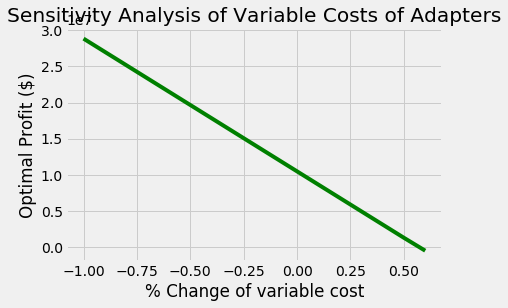

In [104]:
plots.plot(scale_factor_vc, objs_vc, 'g')
plots.title('Sensitivity Analysis of Variable Costs of Adapters')
plots.xlabel('% Change of variable cost')
plots.ylabel('Optimal Profit ($)')

In [105]:
np.corrcoef(scale_factor_vc,objs_vc)

array([[ 1.        , -0.99999933],
       [-0.99999933,  1.        ]])

In [106]:
from sklearn.linear_model import LinearRegression

In [107]:
X = vc_table.column('Profit')
Y = vc_table.column('VC Change')

In [108]:
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

In [109]:
reg = LinearRegression().fit(X, Y)
reg.coef_

array([[-5.45051702e-08]])

The variable cost and the profit are linearly corrolated and obvious highly corrolated (R = 0.99). From the above graph we undestand that the smaller the variable cost of our adapters the higher our profit will be, and the higher our variable costs are the lower our profit. The maximum profit is attained when our VC is null obviously and amounts to 28832100.36. On the other hand, the minimum profit is reached as we increase the variable cost of the adapters until VC equal the selling price of each and onwards and profit decline to 0. It would be wise to find alternatives for the the raw materials. Possibilities include renegociating contract with suppliers or  invest in new machinery to increase production efficiency (reduced labor cost). 

## Section V: Conclusion


All in all, given all the restrictions and costs of American Office Systems remain constant, the maximum computed profit realizable is $ 10475776.514576087 at the end of Q4 1996. The company is obviously facing particular uncertainties which are part of every business. Different sensitivity analyses were conducted to compute the maximum profit attainable under each scenario. Overall, the company has a solid structure and remains profitable within reasonable changes in assumptions. Obviously, the optimal solution of fund allocation varies from one senario to the other but the bottom line remains strong. 

Further analysis of this problem can include an analysis of the tax shield of debt and the impact of an change (sensitivity analysis) in depreciation, in line of credit, and others on the optimal profit. Also, A market research of the demand for the adapters given a selling price increase or decrease can be conducted. Thereafter a very usefull analysis of a change in selling price on the optimal profit would provide interesting insights.

## Author Contributions

Winston Churchill and Joseph Stalin formulated the LP. FDR coded and solved the LP. Winston Churchill and FDR prepared the report. FDR and Stalin conducted sensitivity analysis...
